Member 1 : KEUNG Yat LONG
SID : 5714 6792

Member 2 : Wong Pedro
SID : 56751109

Member 3 : KO Ka Chun
SID : 56744470


# Background
___
- Image generation techniques have existed for decades.
- Recent deep learning advances (GANs, diffusion models) have boosted photorealism in AI-generated content (AIGC).
- While these advancements have entertainment value, they also pose risks of weaponization.
- Detecting AIGC is now a critical issue and a prominent research focus.

# Basic Information
---
- **Main task**: Binary classification (detect whether an image is AI-generated or not).
- **Input**: RGB images.
- **Output**: Binary label indicating if the image is AI-generated.
- **Training set**: 45,000 images.
- **Validation set**: 5,000 images.

# Dataset Exploration
---
- Dataset includes both photographic and AI-generated images.
- Photographic images are sourced from ImageNet with varying sizes.
- AI-generated images are 512 × 512 × 3, created using Stable Diffusion v1.4, trained on the LAION dataset.
- Photographic and AI-generated images have similar semantic content to avoid content bias.
- Only binary labels are available for training and testing.

## Load dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#We used google colab A100 GPU for training the model

Mounted at /content/drive


Please first put the zip file of the dataset into the same folder for loading

In [ ]:
import zipfile
import os

current_dir = os.getcwd()
zip_file_path =  current_dir +'/AIGC-Detection-Dataset.zip'

# Create a directory to extract the dataset
output_dir = 'AIGC_Dataset'
os.makedirs(output_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f'Dataset extracted to {output_dir}')

Dataset extracted to AIGC_Dataset


In [ ]:
import os

# List the contents of the extracted directory
for root, dirs, files in os.walk(output_dir):
    print(f'Root: {root}')
    print(f'Directories: {dirs}')
    print(f'Files: {files[:5]}')  # Show only first 5 files to avoid too much output
    print('---')

Root: AIGC_Dataset
Directories: ['AIGC-Detection-Dataset']
Files: []
---
Root: AIGC_Dataset/AIGC-Detection-Dataset
Directories: ['train', 'val']
Files: []
---
Root: AIGC_Dataset/AIGC-Detection-Dataset/train
Directories: ['0_real', '1_fake']
Files: []
---
Root: AIGC_Dataset/AIGC-Detection-Dataset/train/0_real
Directories: []
Files: ['000000318529.jpg', '000000370724.jpg', '000000148639.jpg', '000000515181.jpg', '000000042501.jpg']
---
Root: AIGC_Dataset/AIGC-Detection-Dataset/train/1_fake
Directories: []
Files: ['000000318529.jpg', '000000370724.jpg', '000000148639.jpg', '000000515181.jpg', '000000042501.jpg']
---
Root: AIGC_Dataset/AIGC-Detection-Dataset/val
Directories: ['0_real', '1_fake']
Files: []
---
Root: AIGC_Dataset/AIGC-Detection-Dataset/val/0_real
Directories: []
Files: ['000000306820.jpg', '000000479376.jpg', '000000379987.jpg', '000000048130.jpg', '000000340331.jpg']
---
Root: AIGC_Dataset/AIGC-Detection-Dataset/val/1_fake
Directories: []
Files: ['000000306820.jpg', '000000

In [ ]:
from PIL import Image
import os

# Example of loading one image
img_path = os.path.join(output_dir, 'AIGC-Detection-Dataset/train/1_fake/000000160232.jpg')
img = Image.open(img_path)

# Display the image
img.show()

# Convert to array for model input
import numpy as np
img_array = np.array(img)
print(img_array.shape)

(512, 512, 3)


1. Upload dataset from Google Drive
2. Extract the dataset (i.e. unzip the dataset)
3. Verify the dataset extraction
4. Proceed with data preprocessing, ensure proper sizing, normalization, and labeling

## Visualizing raw data

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Define the dataset directories
dataset_dir = 'AIGC_Dataset/AIGC-Detection-Dataset'
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')

Function to display images

In [ ]:
def show_images(image_paths, title):
    plt.figure(figsize=(10, 10))
    for i, img_path in enumerate(image_paths):
        plt.subplot(1, len(image_paths), i+1)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

Function to get random images from a class


In [ ]:
def get_random_images(class_dir, num_images=5):
    image_files = os.listdir(class_dir)
    return [os.path.join(class_dir, img) for img in random.sample(image_files, num_images)]

Show some examples of **real images** from the training set

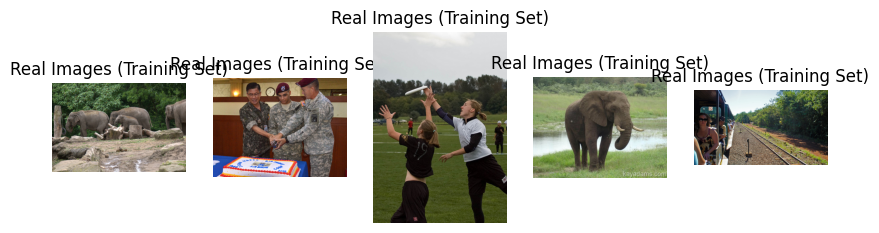

In [ ]:
real_images = get_random_images(os.path.join(train_dir, '0_real'), num_images=5)
show_images(real_images, 'Real Images (Training Set)')

Show some examples of fake (AI-generated) images from the training set

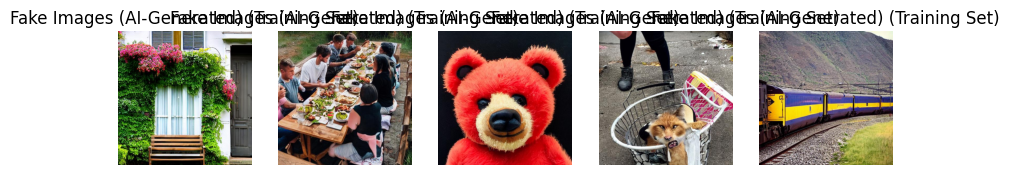

In [ ]:
fake_images = get_random_images(os.path.join(train_dir, '1_fake'), num_images=5)
show_images(fake_images, 'Fake Images (AI-Generated) (Training Set)')

Show some examples of real images from the validation set

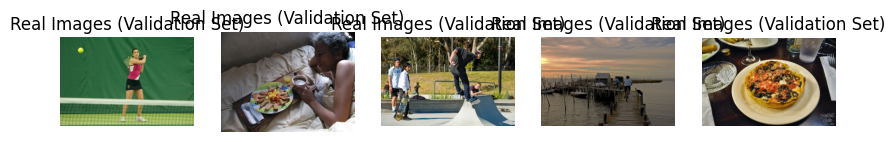

In [ ]:
real_images_val = get_random_images(os.path.join(val_dir, '0_real'), num_images=5)
show_images(real_images_val, 'Real Images (Validation Set)')

Show some examples of fake (AI-generated) images from the validation set

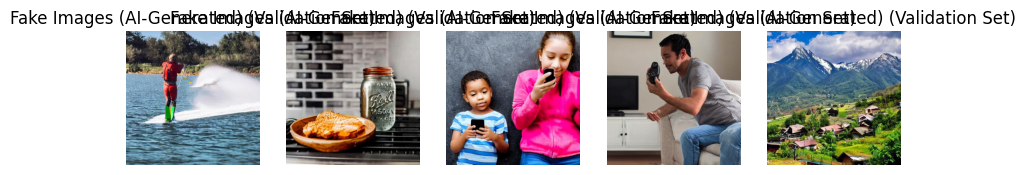

In [ ]:
fake_images_val = get_random_images(os.path.join(val_dir, '1_fake'), num_images=5)
show_images(fake_images_val, 'Fake Images (AI-Generated) (Validation Set)')

1. 5 real images from the training set
2. 5 AI-generated images from the training set
3. 5 real images from the validation set
4. 5 AI-generated images from the validation set

## Data Preprocessing

In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

Define transformations for training data (with augmentation)

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to 512x512
    transforms.RandomRotation(20),  # Random rotation between 0-20 degrees
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomAffine(0, translate=(0.2, 0.2), shear=20),  # Random horizontal and vertical shifts, shear
    transforms.RandomResizedCrop(512, scale=(0.8, 1.2)),  # Random zoom
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet's mean and std
])

Define transformations for validation data (no augmentation, only resizing and normalization)

In [ ]:
val_transforms = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize all validation images to 512x512
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Load the datasets with the ImageFolder utility

In [ ]:
train_data = datasets.ImageFolder('AIGC_Dataset/AIGC-Detection-Dataset/train', transform=train_transforms)
val_data = datasets.ImageFolder('AIGC_Dataset/AIGC-Detection-Dataset/val', transform=val_transforms)

DataLoader - to create batches of data

In [ ]:
# This code train with all data. However, my computing power is not enough
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

## Model Training

In [ ]:
# This code train with all data. However, my computing power is not enough
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

#Model Evaluation

In [ ]:
def evaluate_model(model, val_loader, criterion, device='cuda'):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)

            outputs = model(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # Use only the main output

            outputs = outputs.squeeze(1)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            preds = (outputs > 0.5).float()  # Binary threshold
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    return val_loss, val_acc


## Model Selection

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Save the model to a specified path
def save_model(model, model_name):
    save_path = f"{model_name}_model.pth"  # Save each model with a unique name
    torch.save(model.state_dict(), save_path)
    print(f"{model_name} model saved to {save_path}")


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DenseNet121

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Build DenseNet121 Model
def build_densenet_model():
    base_model = models.densenet121(weights='IMAGENET1K_V1')  # Load pretrained DenseNet121
    num_features = base_model.classifier.in_features
    base_model.classifier = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Linear(512, 1),
        nn.Sigmoid()
    )

    # Freeze base model layers
    for param in base_model.parameters():
        param.requires_grad = False

    # Unfreeze classification layers
    for param in base_model.classifier.parameters():
        param.requires_grad = True

    return base_model

# Initialize DenseNet121 Model
densenet_model = build_densenet_model()

# Optimizer for DenseNet121
densenet_optimizer = optim.Adam(densenet_model.parameters(), lr=0.001)

# Train DenseNet121 Model
train_model(densenet_model, train_loader, val_loader, criterion, densenet_optimizer, num_epochs=5, device=device)
save_model(densenet_model, "DenseNet121")

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 199MB/s]


Epoch 1/5, Loss: 0.1511, Accuracy: 0.9435
Validation Loss: 0.0656, Validation Accuracy: 0.9796
Epoch 2/5, Loss: 0.1150, Accuracy: 0.9586
Validation Loss: 0.0611, Validation Accuracy: 0.9810
Epoch 3/5, Loss: 0.0974, Accuracy: 0.9654
Validation Loss: 0.0698, Validation Accuracy: 0.9794
Epoch 4/5, Loss: 0.0971, Accuracy: 0.9645
Validation Loss: 0.0480, Validation Accuracy: 0.9854
Epoch 5/5, Loss: 0.0847, Accuracy: 0.9691
Validation Loss: 0.0685, Validation Accuracy: 0.9804
DenseNet121 model saved to DenseNet121_model.pth


# Test codes 

> the following codes will be related to the testing part for the test sets.

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from sklearn import metrics
from torch.utils.data import Dataset

In [ ]:
# Define a custom dataset loader for binary classification
class TestDataset(Dataset):
    def __init__(self, data_dir):
        real_dir = os.path.join(data_dir, '0_real')
        fake_dir = os.path.join(data_dir, '1_fake')

        # Load file paths and labels
        self.image_paths = [os.path.join(real_dir, f) for f in os.listdir(real_dir)] + \
                           [os.path.join(fake_dir, f) for f in os.listdir(fake_dir)]
        self.labels = [0] * len(os.listdir(real_dir)) + [1] * len(os.listdir(fake_dir))

        # Image transformations
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        return image, label

In [ ]:
# Define the test function
def test(model, test_dataset_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    # Load test dataset
    test_dataset = TestDataset(test_dataset_path)
    y_true, y_pred = [], []

    for img, label in test_dataset:
        img = img.unsqueeze(0).to(device)  # Add batch dimension
        output = model(img).item()  # Forward pass

        pred = 1 if output > 0.5 else 0  # Sigmoid threshold
        y_true.append(label)
        y_pred.append(pred)

    # Calculate accuracy
    accuracy = metrics.accuracy_score(y_true, y_pred)
    return accuracy

In [ ]:
# Replace these paths before running the test
test_dataset_path = ''  # Replace with the path to the test dataset folder
model_path = 'DenseNet121_model(0.9804).pth'  # Replace with the path to the saved model file

In [ ]:
# Load the trained DenseNet121 model
model = build_densenet_model()
model.load_state_dict(torch.load(model_path))
model.eval()

In [ ]:
# Evaluate the model
accuracy = test(model, test_dataset_path)
print(f"Test Accuracy: {accuracy}")